<a href="https://colab.research.google.com/github/Nikita-Gz/ArGen/blob/main/ArGen_public.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
%tensorflow_version 2.x
%matplotlib inline

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
!pip install ffmpeg-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import PIL
import cv2
import colorsys
import os
import lzma
import shutil
import pickle
import types
import ffmpeg
from google.colab import files
from matplotlib.colors import hsv_to_rgb, rgb_to_hsv
from tensorflow.keras import layers
from zipfile import ZipFile, ZIP_LZMA
from cv2 import VideoWriter, VideoWriter_fourcc
from tensorflow import keras
from PIL import Image
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
import imageio as io

# Input parameters functions

In [4]:
# Creates a 3D matrix, with 1st and 2nd dimensions representing pixels, 3rd dimension specifying coordinates
def create_pixel_coordinate_matrix(resolution, image_centre, coordinate_width, pixel_ratio):
  resolution_ratio = resolution[0] / resolution[1]
  coordinate_height = coordinate_width / (resolution_ratio * pixel_ratio)

  xmin = image_centre[0] - coordinate_width / 2
  xmax = image_centre[0] + coordinate_width / 2

  # inverts height coordinates to be more intuitive
  # update: i don't remember how it helps
  ymin = (image_centre[1] * -1) - coordinate_height / 2
  ymax = (image_centre[1] * -1) + coordinate_height / 2

  x = np.linspace(xmin, xmax, resolution[0], dtype=np.float32)
  y = np.linspace(ymin, ymax, resolution[1], dtype=np.float32)
  xs, ys = np.meshgrid(x, y)
  del x, y
  coordinates = np.stack([xs, ys], axis=-1)
  del xs, ys

  return coordinates

In [5]:
# effects 2D matrices to appends to pixel coordinate matrix

def make_waves(resolution, image_centre, coordinate_width, pixel_ratio, phase=0, freq=1):
  coordinate_matrix = create_pixel_coordinate_matrix(resolution,
                                                     image_centre,
                                                     coordinate_width,
                                                     pixel_ratio)
  distances = np.hypot(coordinate_matrix[:, :, 0], coordinate_matrix[:, :, 1])
  coss = np.cos(distances*freq + phase)
  coss = np.expand_dims(coss, axis=-1)
  return coss


def make_pulses(resolution, image_centre, coordinate_width, pixel_ratio, phase=0, power=2, freq=1):
  coordinate_matrix = create_pixel_coordinate_matrix(resolution,
                                                     image_centre,
                                                     coordinate_width,
                                                     pixel_ratio)
  distances = np.hypot(coordinate_matrix[:, :, 0], coordinate_matrix[:, :, 1])
  coss = ((((np.cos(distances*freq + phase) + 1)/2) ** power) * 2) - 1
  coss = np.expand_dims(coss, axis=-1)
  return coss


def make_switches(resolution, image_centre, coordinate_width, pixel_ratio, phase=0, power=2, freq=1, push=1):
  coordinate_matrix = create_pixel_coordinate_matrix(resolution,
                                                     image_centre,
                                                     coordinate_width,
                                                     pixel_ratio)
  distances = np.hypot(coordinate_matrix[:, :, 0], coordinate_matrix[:, :, 1])
  coss = ((((np.cos(distances*freq + phase) + 1)/2) ** power) * 2) - 1
  sw = (1 / (1 + np.exp(-coss*push))) * 2 - 1
  sw = np.expand_dims(sw, axis=-1)
  return sw


def make_rotation(resolution, image_centre, coordinate_width, pixel_ratio, angle_phase=0, distance_phase=0, angle_freq=1, freq=1, angle_power=1, power=1):
  coordinate_matrix = create_pixel_coordinate_matrix(resolution,
                                                     image_centre,
                                                     coordinate_width,
                                                     pixel_ratio)
  distances = np.hypot(coordinate_matrix[:, :, 0], coordinate_matrix[:, :, 1])
  angles = np.arctan2(coordinate_matrix[:, :, 0], coordinate_matrix[:, :, 1])
  angle_multiplier = ((np.cos(angles*angle_freq+angle_phase)+1)/2)**angle_power
  coss = (((np.cos(distances*freq + distance_phase) + 1)/2) ** power)
  both = (coss * angle_multiplier) * 2 - 1
  sw = np.expand_dims(both, axis=-1)
  return sw

In [6]:
# creates pixel coordinate matrix and appends effects matrices
def create_color_generator_input_matrix(resolution, image_centre, coordinate_width,
                                        pixel_ratio, effects_matrices=None):
  coordinates = create_pixel_coordinate_matrix(resolution, image_centre,
                                               coordinate_width, pixel_ratio)
  
  # concats additional data
  if effects_matrices is not None:
    coordinates = np.concatenate([coordinates, effects_matrices], axis=-1)
  return coordinates

# Color generators

In [7]:
def process_input_in_parts(inp, processing_function, divide_by_n_parts=8):
  blocks = np.array_split(inp, divide_by_n_parts, axis=0)
  outputs = []
  for i, block in enumerate(blocks):
    print("processing block " + str(i+1) + " out of " + str(len(blocks)))
    result = processing_function(block)
    outputs.append(result)

  final_result = np.concatenate(outputs)
  return final_result

In [8]:
class SplitActivation(keras.layers.Layer):

  def __init__(self, activations, split_config=None, split_dim=-1, **kwargs):

    self._split_dim = split_dim
    self._activations = activations
    self._activations_amount = len(self._activations)
    self._is_config_a_list = isinstance(split_config, list)
    self._split_config = None
    
    # assert that split_config size matches with activations amount
    if self._is_config_a_list:
      assert len(split_config) == self._activations_amount, (
        'length of activation sizes list ({}) does not match length of '
        'activations list ({})'
        .format(len(split_config), self._activations_amount))
      self._split_config = split_config
    else:
      self._split_config = self._activations_amount
    
    super(SplitActivation, self).__init__(**kwargs)
    
  def build(self, input_shape):
    split_dim_size = input_shape[self._split_dim]
    
    if self._is_config_a_list:
      assert sum(self._split_config) == split_dim_size, (
        'sum of split sizes ({}) does not match the split dimension size ({})'
        .format(sum(self._split_config), split_dim_size))
    else:
      assert (split_dim_size % self._activations_amount) == 0, (
        'last dimension (size {}) cannot be evenly split across '
        'activations (size {})'
        .format(split_dim_size, self._activations_amount))
    
    super(SplitActivation, self).build(input_shape)
    
  
  def call(self, x):
    split_input = tf.split(x, self._split_config, axis=self._split_dim)
    
    x = tf.concat([activation(input_slice) for input_slice, activation
                   in zip(split_input, self._activations)],
                  axis=self._split_dim)
    return x

In [9]:
@tf.function
def distance(x):
  return tf.norm(x, axis=-1, keepdims=True)

In [10]:
class ColorGenerator:
  _color_generator_function = None

  def __init__(self, color_generator_function=None):
    self._color_generator_function = color_generator_function

  # assumes color function results are from -1 to 1, converts them to 0..255 ints
  def convert_color_values_to_rgb(self, colors_matrix):
    scaled = ((colors_matrix + 1) / 2) * 255
    integer_colors = scaled.astype(np.uint8)
    return integer_colors

  def __call__(self, input_data):
    color_function_results = process_input_in_parts(input_data,
                                                    self._color_generator_function)
    converted_to_rgb = self.convert_color_values_to_rgb(color_function_results)
    return converted_to_rgb

In [11]:
# assumes color function results are from -1 to 1, interprets them as HSV values and converts to 0..255 ints RGB
def convert_color_values_to_rgb_as_hsv(x):
  converted = (x + 1) / 2
  
  # assignis 0 to pixels with NAN channels
  nan_mask = np.expand_dims(np.isnan(converted).any(axis=-1), axis=-1).repeat(3, axis=-1)
  converted[np.where(nan_mask)] = 0
 
  converted = (hsv_to_rgb(converted) * 255).astype(np.uint8)
  return converted

In [19]:
class StairsGenerator(ColorGenerator):
  def __init__(self):
    super(StairsGenerator, self).__init__(keras.Sequential([
      keras.layers.Dense(16,
                        bias_initializer=keras.initializers.RandomNormal(0, 0.5)),
      SplitActivation([tf.nn.relu, tf.math.sin]),
      keras.layers.Dense(16,
                        bias_initializer=keras.initializers.RandomNormal(0, 0.2)),
                        #bias_initializer=keras.initializers.RandomNormal(0, 0.2)),
      SplitActivation([tf.nn.relu, tf.math.ceil]),
      keras.layers.Dense(16,
                        kernel_initializer=keras.initializers.RandomNormal(0, 0.1),
                        bias_initializer=keras.initializers.RandomNormal(0, 0.2)),
      SplitActivation([tf.nn.relu, tf.math.sin]),

      keras.layers.Dense(3,
                        activation='tanh'),
    ]))

# Creating the image

In [134]:
color_generator = StairsGenerator()

processing block 1 out of 8
processing block 2 out of 8
processing block 3 out of 8
processing block 4 out of 8
processing block 5 out of 8
processing block 6 out of 8
processing block 7 out of 8
processing block 8 out of 8


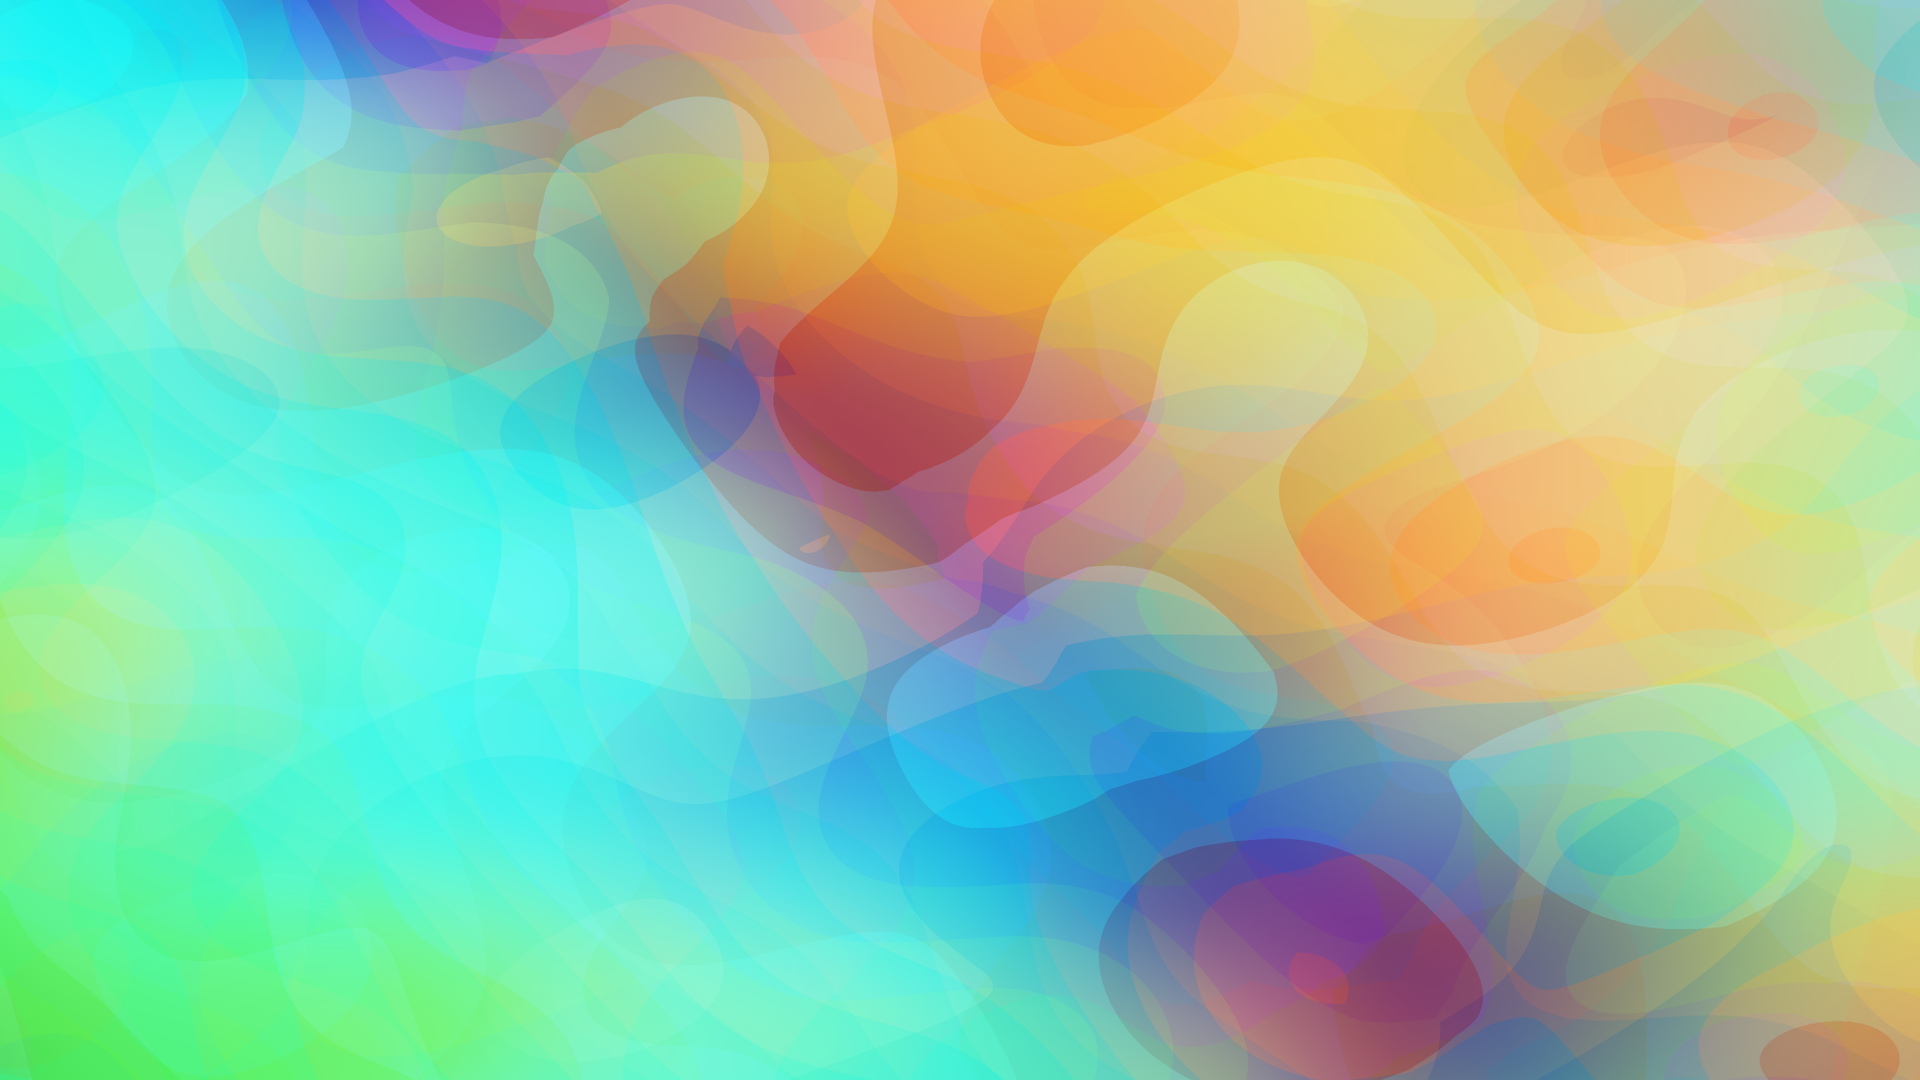

In [135]:
res = (1920 * 2, 1080 * 2)
centre = (0, 0)
width = 50
pixel_ratio = 1
input_matrix = create_color_generator_input_matrix(res, centre, width, pixel_ratio)
color_output_rgb_matrix = color_generator(input_matrix)
Image.fromarray(color_output_rgb_matrix).resize((res[0] // 2, res[1] // 2), resample=PIL.Image.BICUBIC)

# Image with simple effects

In [143]:
color_generator = ColorGenerator(keras.Sequential([
      #keras.layers.Dense(60,
  #                   kernel_initializer=keras.initializers.RandomNormal(0, 0.5)),
  #SplitActivation([tf.math.cos, tf.nn.relu6, distance]),

  keras.layers.Dense(132, kernel_initializer=keras.initializers.RandomNormal(1, 5)),
  SplitActivation([tf.math.tanh, tf.math.sin,
                   keras.layers.Dense(20, kernel_initializer=keras.initializers.RandomNormal(0, 0.05), activation=tf.sin)]),

  keras.layers.Dense(130, kernel_initializer=keras.initializers.RandomNormal(0, 5),
                     bias_initializer=keras.initializers.RandomNormal(0, 40)),
  SplitActivation([tf.math.tanh, tf.nn.relu6]),
  keras.layers.Dense(130, kernel_initializer=keras.initializers.RandomNormal(0, 5),
                     bias_initializer=keras.initializers.RandomNormal(0, 4)),
  SplitActivation([tf.math.tanh,
                   lambda x: tf.nn.relu6(tf.math.log(x**2))]),
  #keras.layers.Dense(60,),
  #SplitActivation([tf.math.sin]),

  # keras.initializers.RandomNormal(0, 0.25)
  SplitActivation([tf.nn.softmax]),
  keras.layers.Dense(30, kernel_initializer=keras.initializers.RandomNormal(0, 5)),

      keras.layers.Dense(3,
                        activation='tanh'),
    ]))

processing block 1 out of 8
processing block 2 out of 8
processing block 3 out of 8
processing block 4 out of 8
processing block 5 out of 8
processing block 6 out of 8
processing block 7 out of 8
processing block 8 out of 8


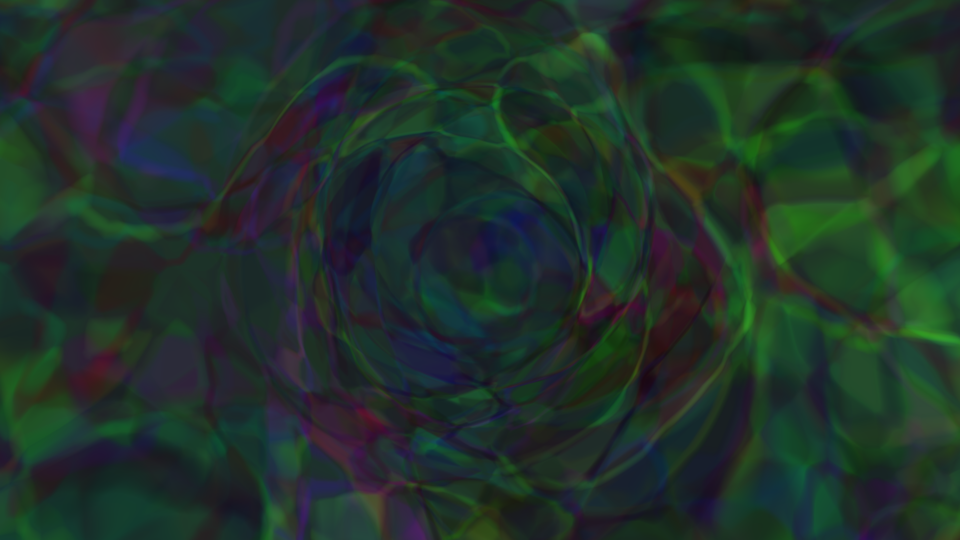

In [144]:
width = 0.75
waves_effect = make_switches(res, (0, 0), width, 1, phase=0, power=4, push=1, freq=6) * 0.5
input_matrix = create_color_generator_input_matrix(res, centre, width, pixel_ratio, waves_effect)
color_output_rgb_matrix = color_generator(input_matrix)
Image.fromarray(color_output_rgb_matrix).resize((res[0] // 4, res[1] // 4), resample=PIL.Image.BICUBIC)

# Image with advanced effects

In [49]:
# i wrote the code for this effect a year ago, do not try to understand it
def make_final_input_vortex(i, resolution, centre, original_width, pixel_ratio, seconds, video_fps):
  frames_in_animation = seconds * video_fps
  phase = 0 
  whole_rotation_multiplier = 2 * np.pi / frames_in_animation
  #movement_progress = (-np.cos(i * whole_rotation_multiplier + phase) + 1) * 0.5
  #movement_direction = np.sin(i * whole_rotation_multiplier + phase)

  pulsing_phase = (-i * (np.pi * 2 / (frames_in_animation/2)))
  pulse_sin_norm = (np.sin(pulsing_phase) + 1) / 2

  zoom_out_distance = original_width * 0.25
  width = original_width + (pulse_sin_norm**16 * zoom_out_distance)

  mtx = create_color_generator_input_matrix(resolution, centre, width, pixel_ratio)
  dists = np.hypot(mtx[:, :, 0], mtx[:, :, 1])
  hole_radius_overkill = 1
  #hole_radius = (original_width / 1.5) * (1 - (pulse_sin_norm**16 * hole_radius_overkill)) + (np.sin(i * whole_rotation_multiplier * 6) * original_width / 30)
  #hole_radius = (original_width / 2.2) * (1 - (pulse_sin_norm**16 * hole_radius_overkill)) + (np.sin(i * whole_rotation_multiplier * 6) * original_width / 30)
  hole_radius = (original_width / 6) * (1 - (pulse_sin_norm**16 * hole_radius_overkill)) + (np.sin(i * whole_rotation_multiplier * 6) * original_width / 30)
  holed_distance = -(hole_radius - dists)
  holed_distance[holed_distance < 0] = np.nan
  del dists
  #rotation_amount = (0.2 / (((holed_distance*(np.pi / 30))**2) + 0.04)) + (i * whole_rotation_multiplier)
  rotation_amount = (0.2 / (((holed_distance*(np.pi / 30))**2) + 0.06)) + (i * whole_rotation_multiplier)

  #subspace_bulge = ((-original_width/4) * np.exp(-(holed_distance - hole_radius/3)**2 / (1 + pulse_sin_norm**16))) + np.sin(i * whole_rotation_multiplier) * 4
  subspace_bulge = ((-original_width/4) * np.exp(-(holed_distance - hole_radius/4)**2 / (1 + pulse_sin_norm**16))) + np.sin(i * whole_rotation_multiplier) * 4

  pulsing = ((((np.sin((holed_distance * (np.pi * 2 / (original_width/0.25))) + (- pulsing_phase + (np.pi/2 + np.pi/5.5))) + 1) / 2)**128) * (original_width*0.25)
             / (holed_distance*0.1 + 0.5))
  del holed_distance

  rotated_x = (mtx[:, :, 1] * np.cos(-rotation_amount) - mtx[:, :, 0] * np.sin(-rotation_amount))
  rotated_y = (mtx[:, :, 1] * np.sin(-rotation_amount) + mtx[:, :, 0] * np.cos(-rotation_amount))
  del mtx
  del rotation_amount

  #consta = np.ones_like(rotated_x) * np.sin(i * whole_rotation_multiplier) * 4
  final_input = np.stack([rotated_y, rotated_x, subspace_bulge, pulsing], axis=-1)
  del rotated_y
  del rotated_x
  del subspace_bulge
  del pulsing
  return final_input

In [53]:
stairs_generator = StairsGenerator()

In [57]:
target_resolution = (1920, 1080)
supersampling_multiplier = 8
supersampling_resolution = [size * supersampling_multiplier for size in target_resolution]
input_data = make_final_input_vortex(0, supersampling_resolution, centre, 50, 1,
                                     seconds=20,
                                     video_fps=60)

processing block 1 out of 8
processing block 2 out of 8
processing block 3 out of 8
processing block 4 out of 8
processing block 5 out of 8
processing block 6 out of 8
processing block 7 out of 8
processing block 8 out of 8


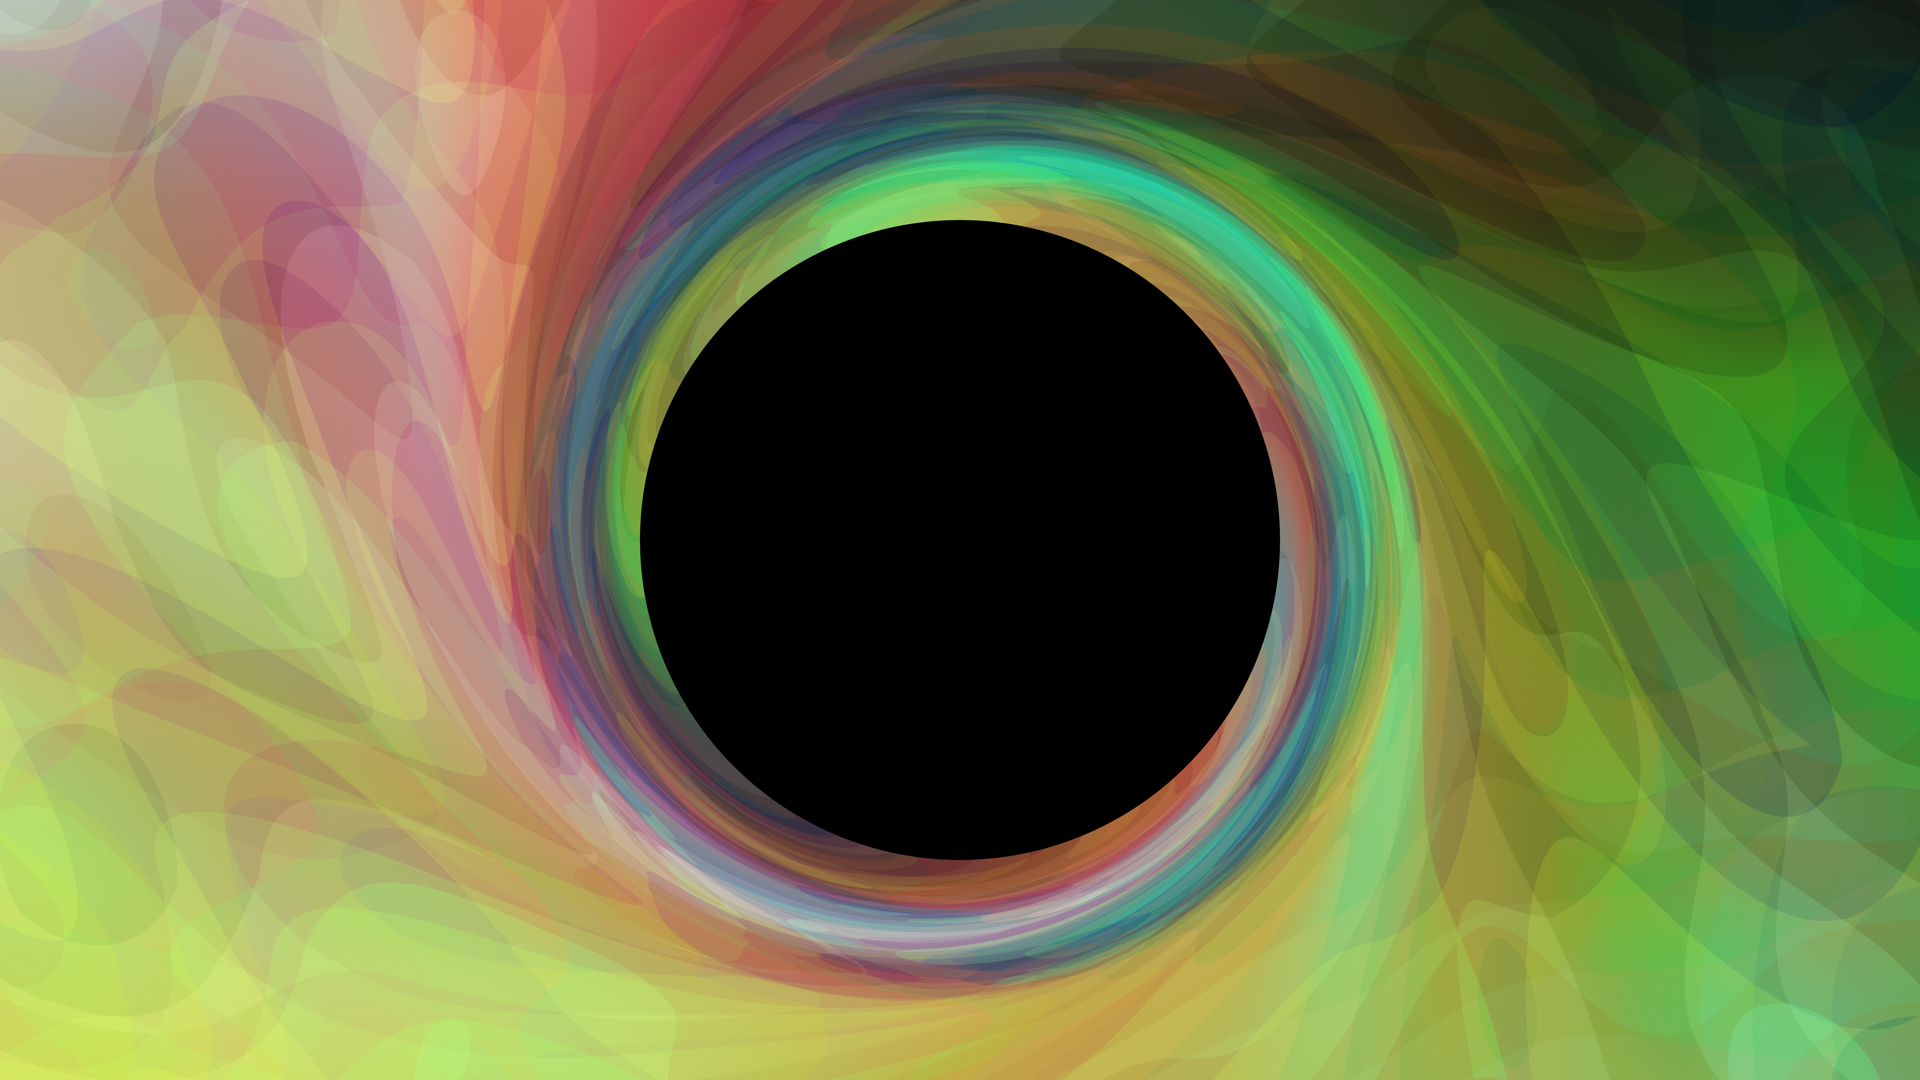

In [59]:
color_output_rgb_matrix = stairs_generator(input_data)
Image.fromarray(color_output_rgb_matrix).resize(target_resolution, resample=PIL.Image.BICUBIC)

# Animation

Generating 30 frames
processing block 1 out of 8
processing block 2 out of 8
processing block 3 out of 8
processing block 4 out of 8
processing block 5 out of 8
processing block 6 out of 8
processing block 7 out of 8
processing block 8 out of 8


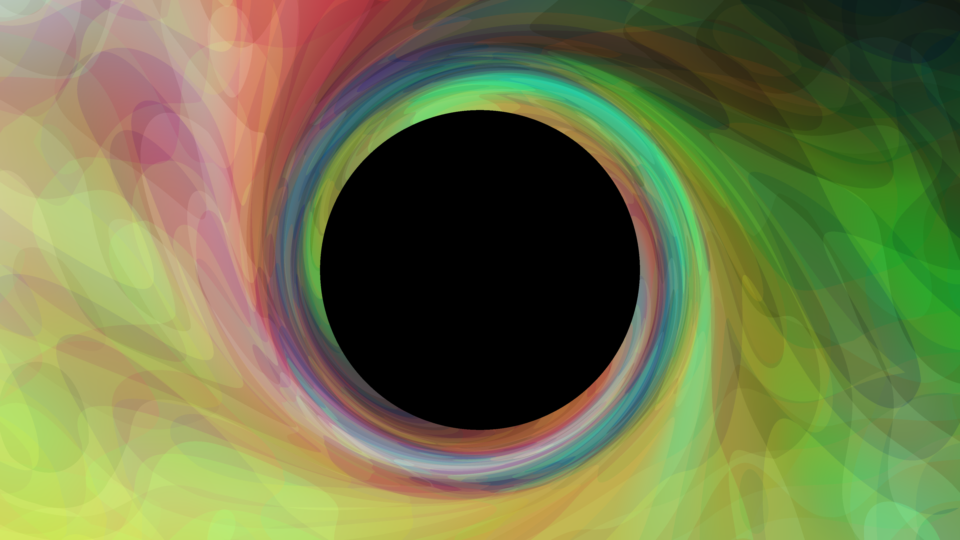

saving
saved
frame 0 done
processing block 1 out of 8
processing block 2 out of 8
processing block 3 out of 8
processing block 4 out of 8
processing block 5 out of 8
processing block 6 out of 8
processing block 7 out of 8
processing block 8 out of 8
saving
saved
frame 1 done
processing block 1 out of 8
processing block 2 out of 8
processing block 3 out of 8
processing block 4 out of 8
processing block 5 out of 8
processing block 6 out of 8
processing block 7 out of 8
processing block 8 out of 8
saving
saved
frame 2 done
processing block 1 out of 8
processing block 2 out of 8
processing block 3 out of 8
processing block 4 out of 8
processing block 5 out of 8
processing block 6 out of 8
processing block 7 out of 8
processing block 8 out of 8
saving
saved
frame 3 done
processing block 1 out of 8
processing block 2 out of 8
processing block 3 out of 8
processing block 4 out of 8
processing block 5 out of 8
processing block 6 out of 8
processing block 7 out of 8
processing block 8 out of 8


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [60]:
video_fps = 60
seconds = 10
frame_count = video_fps * seconds
display_frame_every = 60
target_resolution = (1920, 1080)
supersampling_multiplier = 2
supersampling_resolution = [size * supersampling_multiplier for size in target_resolution]
centre = (0, 0)
width = 50
pixel_ratio = 1

display_coefficient = 0.5
display_size = (int(target_resolution[0]*display_coefficient),
                int(target_resolution[1]*display_coefficient))

process = (
        ffmpeg
            .input('pipe:', format='rawvideo', pix_fmt='rgb24', s='{}x{}'.format(target_resolution[0], target_resolution[1]), r=video_fps)
            .output('animation.mp4', pix_fmt='yuv420p', crf=15, vcodec='h264')
            .overwrite_output()
            .run_async(pipe_stdin=True)
    )

try:
  shutil.rmtree('./render_imgs')
except:
  pass
os.mkdir("render_imgs")
frames_limit = video_fps * seconds
print('Generating {} frames'.format(frames_limit))
for i in range(frames_limit):
  final_input = make_final_input_vortex(i, supersampling_resolution, centre, width, 1, seconds, video_fps)

  #out = model(np.expand_dims(final_input, 0))[0]
  output = stairs_generator(final_input)
  img = Image.fromarray(output)

  if i % display_frame_every == 0:
      displayed_image = img.resize(display_size, resample=PIL.Image.BILINEAR)
      display(displayed_image)
    
  img = img.resize(target_resolution, resample=PIL.Image.BICUBIC)

  print('saving')
  process.stdin.write(np.asarray(img).astype('uint8').tobytes())
  #img_viewable.save("./render_imgs/img-{}.png".format(i), format="png")
  print('saved')

  #frame = np.asarray(img_viewable)
  #video.write(frame[..., ::-1])
  print('frame {} done'.format(i))

process.stdin.close()
process.wait() 
files.download('animation.mp4')
#video.release()